In [23]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
import eleanor
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import elisa

plt.rcParams['font.size'] = 16

star = eleanor.Source(tic=91961, sector='recent')
print(star.tic, star.coords, star.gaia)

No eleanor postcard has been made for your target (yet). Using TessCut instead.
91961 [221.697546388559, -23.9201181491088] 6230262246566057728


[2334.18990112 2334.19684566 2334.2037902  ... 2360.53690124 2360.54384547
 2360.55078971]
[ 973.22930399  999.4508926  1012.47667485 ... 1022.2512832  1029.11714393
 1025.37304945]


Text(0.5, 1.0, 'TIC-91961')

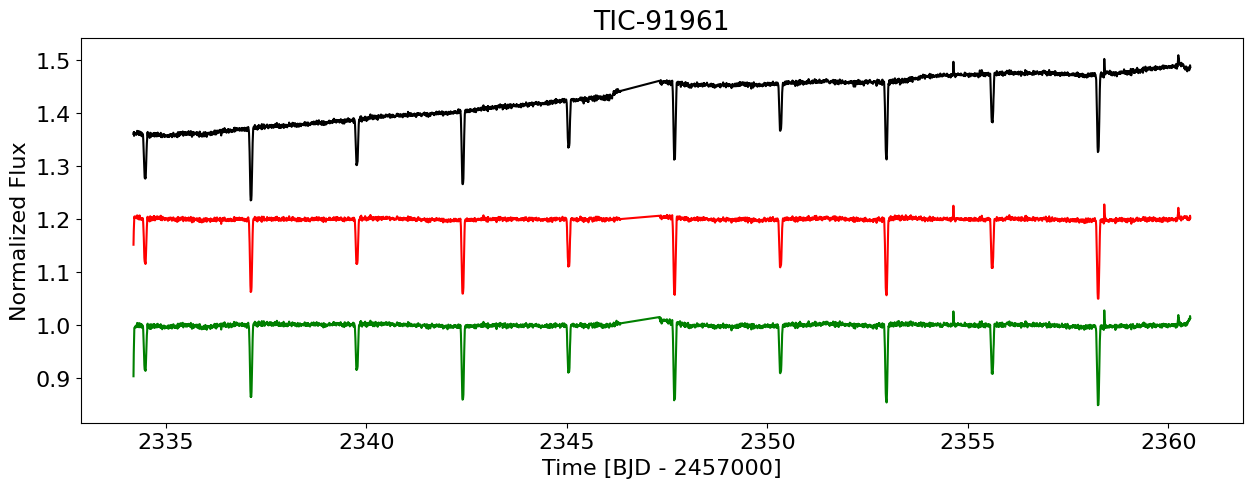

In [24]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=True, regressors='corner')
plt.figure(figsize=(15,5))

q = data.quality == 0

print(data.time[q])
print(data.corr_flux[q])

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]) + 0.45, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.2, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
# plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('TIC-91961')

In [65]:
columns = np.column_stack((data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]), data.flux_err[q]/np.nanmedian(data.corr_flux[q])))
np.savetxt('E:\Coding\PyCharm Python Projects\light curve testing\data.dat', columns, fmt=('%.9f', '%.9f', '%.3e'), delimiter='     ')

In [66]:
lk = data.to_lightkurve()
period = np.linspace(1, 15, 10000)
bls = lk.to_periodogram(method='bls', period=period, frequency_factor=500)

period = bls.period_at_max_power.value * 2
t0 = bls.transit_time_at_max_power.value
duration = bls.duration_at_max_power

period, t0, duration

(5.284728472847284, 2334.4749011186673, <Quantity 0.05 d>)

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

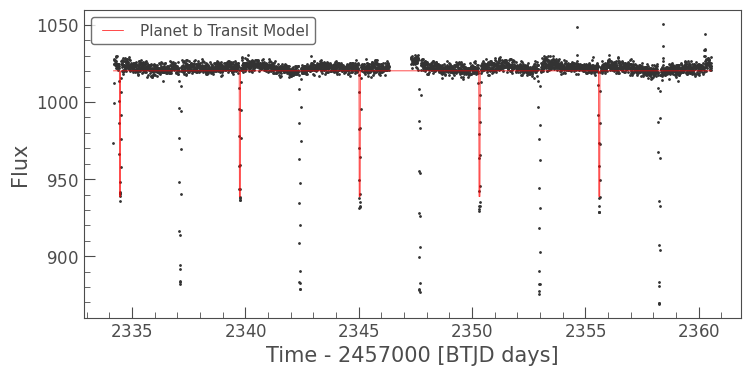

In [67]:
planet_model = bls.get_transit_model(period=period, transit_time=t0, duration=duration)
ax = lk.scatter()
planet_model.plot(ax=ax, c='r', label='Planet b Transit Model')

In [90]:
import os
from elisa import settings
from elisa.analytics import LCData, LCBinaryAnalyticsTask

settings.configure(LOG_CONFIG='fit')
elisa_data = LCData.load_from_file(filename='E:\Coding\PyCharm Python Projects\light curve testing\data.dat', x_unit=None, y_unit=None)

elisa_data.convert_to_phases(period, t0, centre=0.0)

lc_initial = {
    'system': {
        # setting a reasonable expected starting value and range of the parameters
        'inclination': {
            'value': 76.0,
            'fixed': False,
            'min': 65,
            'max': 90,
            'unit': u.deg
        },
        'eccentricity': {
            'value': 0.02,
            'fixed': False,
            'min': 0.0,
            'max': 0.1,
        },
        'mass_ratio': {
            'value': 1.00,
            'fixed': False,
            'min': 0.25,
            'max': 4.0,
        },
        'argument_of_periastron': {
            'value': 300,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },
        # this parameter is constrained to orbital inclination via the `asini` derived during the RV fit
        'semi_major_axis': {
            'value': 7.0,
            'fixed': False,
            'min': 1.0,
            'max': 100.0,
            'unit': u.solRad
        },
        'period': {
            'value': period,
            'fixed': True,
            'unit': u.d
        },
        # this parameter allows for the presence of the third light
        'additional_light': {
            'value': 0.0,
            'fixed': False,
            'min': 0.0,
            'max': 0.5,
        },
        # accounting for imprecision of the ephemeris
        'phase_shift': {
            'value': 0,
            'fixed': False,
            'min': -0.02,
            'max': 0.02,
        },
        # 'primary_minimum_time': {
        #     'value': 54953.900507000006,
        #     'fixed': True,
        #     'unit': u.d,
        # }, time of primary minimum should be supplied only in case when LCData contain light curves in BJD
        # instad of photometric phase
    },
    'primary': {
        # initial run will keep the primary effective temperature fixed on the value derived in the literature (Armstrong et al. 2013, MNRAS, 437, 4, 3473–3481)
        't_eff': {
            'value': 6000.0,
            'fixed': False,
            'min': 4000.0,
            'max': 10000.0,
            'unit': u.K
        },  # fixed to value found in literature
        'surface_potential': {
            'value': 6.1,
            'fixed': False,
            'min': 5.0,
            'max': 10.0,
        },
        # albedos and gravity darkening factors will stay fixed for the initial run
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        # assuming synchronized rotation at periastron
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    },
    'secondary': {
        't_eff': {
            'value': 7000.0,
            'fixed': False,
            'min': 3500.0,
            'max': 12000.0,
            'unit': u.K
        },
        'surface_potential': {
            'value': 6.2,
            'fixed': False,
            'min': 4.0,
            'max': 10.0,
        },
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    }
}

['bolometric', 'Generic.Bessell.U', 'Generic.Bessell.B', 'Generic.Bessell.V', 'Generic.Bessell.R', 'Generic.Bessell.I', 'SLOAN.SDSS.u', 'SLOAN.SDSS.g', 'SLOAN.SDSS.r', 'SLOAN.SDSS.i', 'SLOAN.SDSS.z', 'Generic.Stromgren.u', 'Generic.Stromgren.v', 'Generic.Stromgren.b', 'Generic.Stromgren.y', 'Kepler', 'GaiaDR2', 'TESS']
2022-11-06 21:55:10,252 - 22852 - binary_system.curves.c_router - INFO: one half of the curve points on the one side of the apsidal line will be interpolated


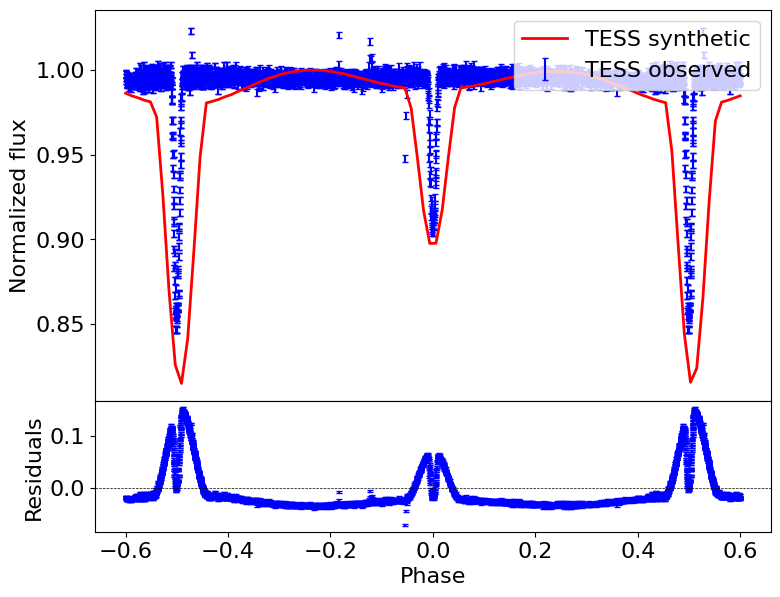

In [91]:
print(settings.PASSBANDS)
lst_sqr_task = LCBinaryAnalyticsTask(data={'TESS': elisa_data}, method='least_squares', expected_morphology="detached")
lst_sqr_task.set_result(lc_initial)
lst_sqr_task.plot.model(discretization=10, number_of_points=100, start_phase=-0.6, stop_phase=0.6)

In [83]:
lst_sqr_result = lst_sqr_task.get_result()
lst_sqr_task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                              1.0                   -                   -                   -    Variable                                          
Semi major axis (a):                                10.0                   -                   -              solRad    Variable                                          
Inclination (i):                                    76.0                   -                   -                 deg    Variable                                          
Eccentricity (e):                                   0.02                   -                   -                   -    Variable                                          
Arg

In [94]:
settings.configure(NUMBER_OF_PROCESSES=4)

param_file = 'E:\Coding\PyCharm Python Projects\light curve testing\lc_least_squares.json'

lst_sqr_result = lst_sqr_task.fit(x0=lc_initial, discretization=10, interp_treshold=100, samples='adaptive')
lst_sqr_task.save_result(param_file)

2022-11-06 22:01:43,281 - 22852 - analytics.binary_fit.shared - INFO: Generating equidistant samples along the light curve using adaptive sampling method
2022-11-06 22:01:54,223 - 22852 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2022-11-06 22:02:16,284 - 22852 - analytics.binary_fit.least_squares - INFO: fitting started...
2022-11-06 22:02:17,458 - 22852 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2022-11-06 22:02:22,991 - 22852 - analytics.binary_fit.least_squares - INFO: current R2: -3.685176652128497
2022-11-06 22:02:24,138 - 22852 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2022-11-06 22:02:29,645 - 22852 - analytics.binary_fit.le

KeyboardInterrupt: 